In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xbg

color_plt = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [3]:
df = df.set_index('Datetime')
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [4]:
df.index = pd.to_datetime(df.index)

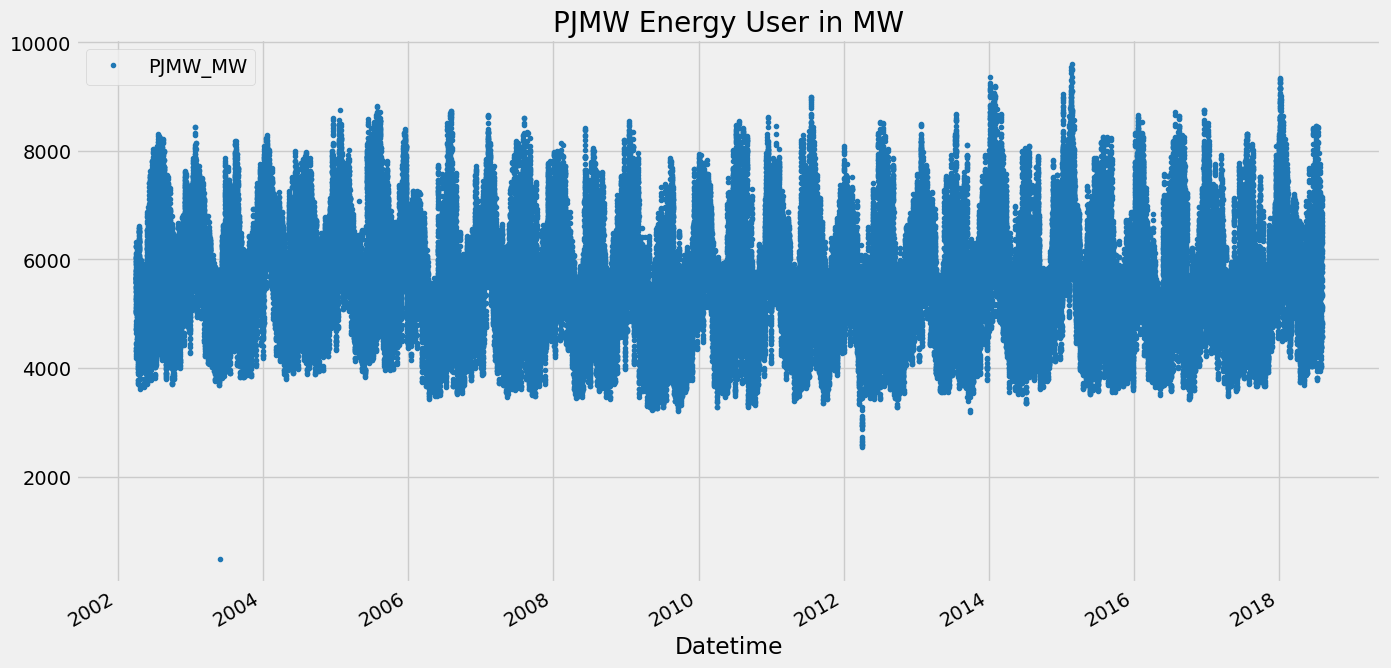

In [5]:
df.plot(style='.', figsize=(15, 8),
        color=color_plt[0], title='PJMW Energy User in MW')
plt.show()

# Train Test Split

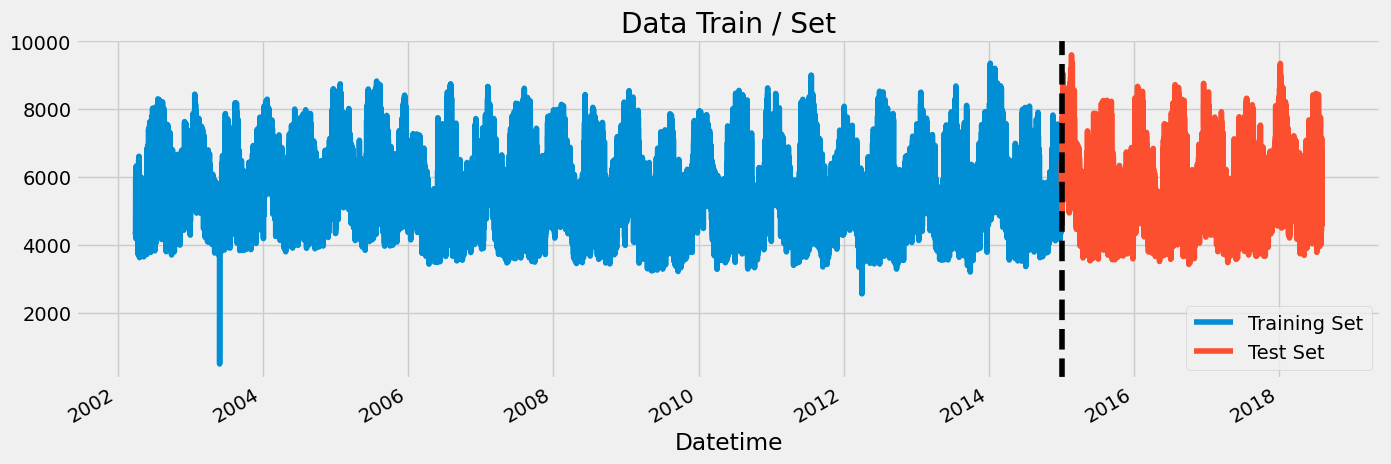

In [7]:
train = df.iloc[df.index < '01-01-2015']
test = df.iloc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training Set', title='Data Train / Set')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2015', color='black', ls='--')  # untuk membuat garis pemisah
ax.legend(['Training Set', 'Test Set'])
plt.show()


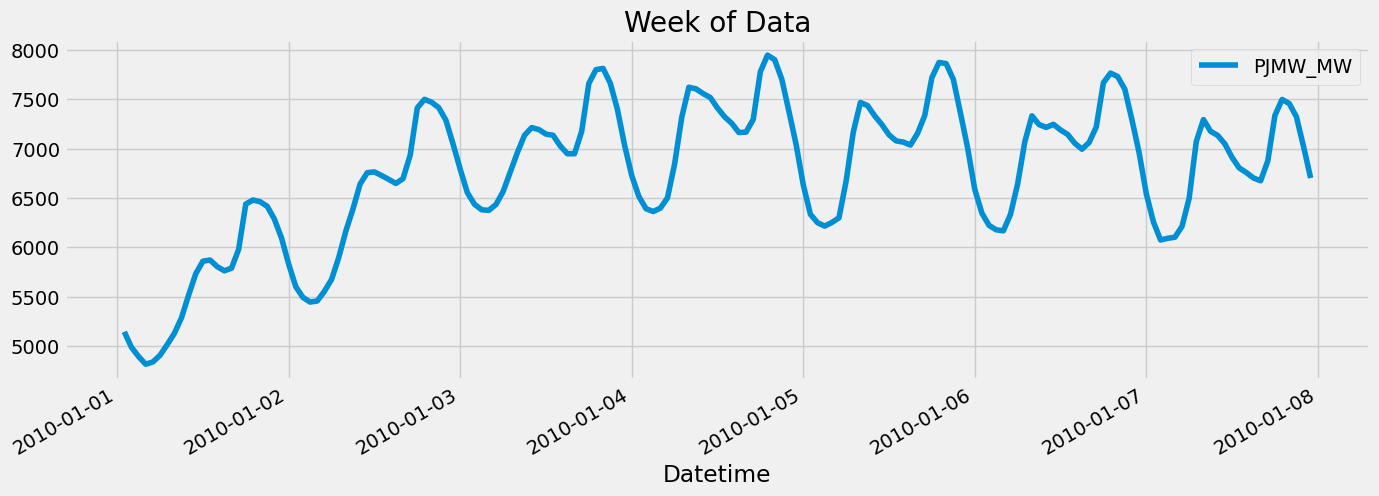

In [8]:
df.iloc[(df.index > '01-01-2010') & (df.index < '01-08-2010')
        ].plot(figsize=(15, 5), title='Week of Data')
plt.show()


# Feature Creation

In [9]:
def feature_creation(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [10]:
df = feature_creation(df)

# Create Our Model

In [11]:
train = feature_creation(train)
test = feature_creation(test)


In [12]:
df.columns

Index(['PJMW_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [13]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear']

TARGET = 'PJMW_MW'


In [14]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

model = xbg.XGBRegressor(
    n_estimators=100, early_stopping_rounds=50, learning_rate=0.1, max_depth=9)
model.fit(x_train, y_train, eval_set=[
          (x_train, y_train), (x_test, y_test)], verbose=100)


[0]	validation_0-rmse:5118.85498	validation_1-rmse:5136.21449
[88]	validation_0-rmse:260.01790	validation_1-rmse:700.32570


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

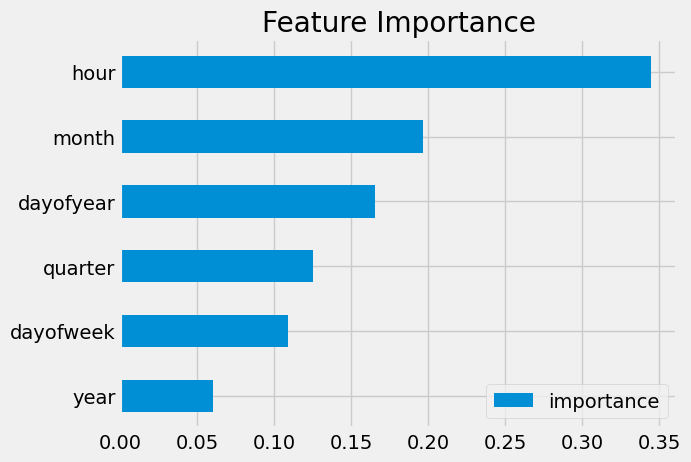

In [69]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Forecast on Test

In [72]:
test['prediction'] = model.predict(x_test)

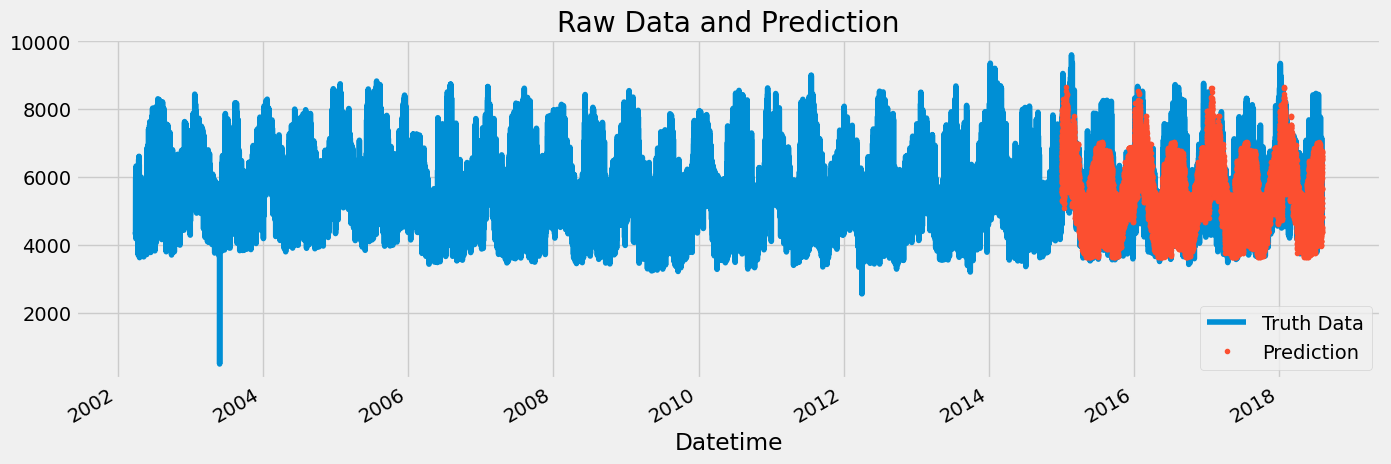

In [73]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJMW_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()